In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as nnFunctional
import pdb
import torch.nn as nn
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import os
import torch
import torch.nn as nn
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

In [2]:
(train, validation, test), info = tfds.load(
    
    "patch_camelyon",
    split = ["train", "validation", "test"],
    shuffle_files = True, 
    as_supervised = True,
    with_info = True,  
)

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

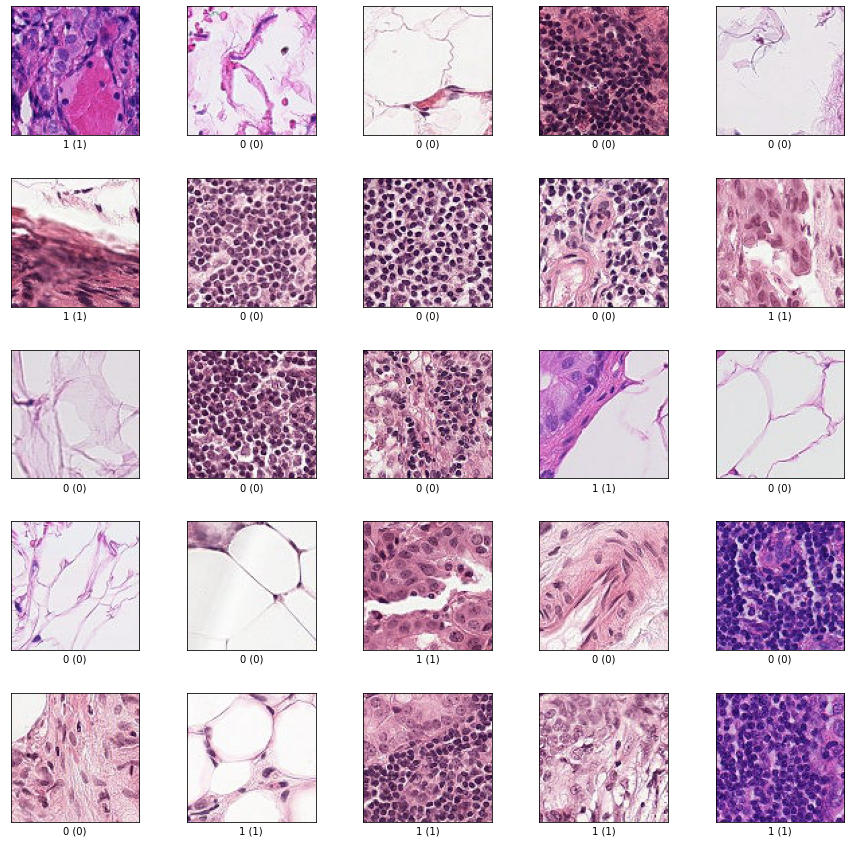

In [4]:
fig = tfds.show_examples(train, info, rows = 5, cols = 5)

In [5]:
# Normalize the images
def normalize(image, label):
  return tf.cast(image, tf.float16)/255.0, label

In [6]:
def augm(image_label, seed):
  image, label = image_label
  image, label = normalize(image, label)
  return image, label

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

In [8]:
counter = tf.data.experimental.Counter()
ds_train = tf.data.Dataset.zip((train, (counter, counter)))

In [9]:
train = train.map(normalize, num_parallel_calls = AUTOTUNE)
train = train.cache()
train = train.shuffle(info.splits["train"].num_examples)

train = train.batch(BATCH_SIZE)
train = train.prefetch(AUTOTUNE)

In [10]:
validation = validation.map(normalize, num_parallel_calls = AUTOTUNE)
validation = validation.batch(32)
validation = validation.prefetch(AUTOTUNE)

In [11]:
test = test.map(normalize, num_parallel_calls = AUTOTUNE)
test = test.batch(32)
test = test.prefetch(AUTOTUNE)

In [12]:
# This is a base block for ResNet that will not expend
class block(nn.Module):
  expansion = 1
  def __init__(self, input,out_channels, stride=1, dimension_change=None):
    super(block, self).__init__()

    # Batch normalization while declaring the convolutional layers
    self.conv1 = nn.Conv2(input, out_channels, stride=stride, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2(input, out_channels, stride=1, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.relu = nn.ReLu()
    self.dimension_change = dimension_change
  
  def forward(self, x):
    # Save the residue
    residue = x
    output = nnFunctional.relu(self.bn1(self.conv1(x)))
    output = self.bn2(self.conv2(output))

    if self.dimension_change is not None:
      residue = self.dimension_change(residue)
      
    output = output + residue
    output = nnFunctional.relu(x)

    return output


class bottleNeck(nn.Module):
  expansion = 4
  def __init__(self, input,out_channels, stride=1, dimension_change=None):
    super(bottleNeck, self).__init__()

    self.conv1 = nn.Conv2d(input, out_channels, kernel_size=1, stride=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding =1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size = 1)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.dimension_change = dimension_change

  def forward(self, x):
    # Save the residue
    residue = x
    output = nnFunctional.relu(self.bn1(self.conv1(x)))
    output = nnFunctional.relu(self.bn2(self.conv2(output)))
    output.self.bn3(self.conv3(output))

    if self.dimension_change is not None:
      residue = self.dimension_change(residue)
      
    output = output + residue
    output = nnFunctional.relu(x)

    return output

In [13]:
# Building the ResNet using the code above

class ResNet(nn.Module):
  def __init__(self, block, number_layers, classes=2):
    super(ResNet, self).__init__()
    self.input = 64
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(64)

    self.layer1 = self.create_layer(block, 64, number_layers[0], stride=1)
    self.layer2 = self.create_layer(block, 128, number_layers[1], stride=2)
    self.layer3 = self.create_layer(block, 256, number_layers[2], stride=2)
    self.layer4 = self.create_layer(block, 512, number_layers[3], stride=2)

    self.averagePool = nn.AvgPool2d(kernel_size=4, stride=1)
    self.fc = nn.Linear(512*block.expansion, classes)
 
  def create_layer(self, block, planes, number_layers, stride=1):
    dimension_change = None
    if stride != 1 or planes != self.input*block.expansion:
      dimension_change = nn.Sequential  (nn.Conv2d(self.input, planes*block.expansion, kernel_size = 1, stride = stride),
                                         nn.BatchNorm2d(planes*block.expansion))
      nested_layers =[]
      nested_layers.append(block(self.input, planes, stride=stride, dimension_change = dimension_change))
      self.input = planes * block.expansion
      for i in range (1, number_layers):
        nested_layers.append(block(self.input, planes))
        self.input = planes*block.expansion

      return nn.Sequential(*nested_layers)

  def forward(self, x):
    x = nnFunctional(self.bn1(self.conv1(x)))

    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)

    return x

In [14]:
# Test function

def test():

  #ResNet-50 Architecture
  net = ResNet(bottleNeck, [3,4,6,3])
  optimizer = torch.optim.SGD(net.parameters(), lr=0.02, momentum=0.9)

  for epoch in range(100):
    closs = 0
    for i, batch in enumerate(train,0):
      data,output = batch
      prediction = net(data)
      loss = nn.CrossEntropyLoss(prediction, output)
      closs = loss.item()

      optimizer.zero_gra()
      loss.backward()
      optimizer.step()

      if i%100 == 0:
        print('[%d  %d] loss: %.4f'% (epoch+1, i+1, closs/1000))
        closs = 0
    
    correctPred = 0
    total = 0

    for batches in validation:
      data, output = batches
      prediction = net(data)
      _,prediction = torch.max(prediction.data, 1) #returns max and its index
      total += output.size(0)
      correctPred += (prediction==output).sum().item()
    print('Accuracy on epoch ', epoch+1, '=', str((correctPred/total)*100))
  
  correctPred = 0
  total = 0
  for batches in validation:
    data, output = batches
    prediction = net(data)
    _,prediction = torch.max(prediction.data, 1) #returns max and its index
    total += output.size(0)
    correctPred += (prediction==output).sum().item()
  print('Accuracy on epoch ', epoch+1, '=', str((correctPred/total)*100))


In [ ]:
if __name__ =='__main__':
  test()